<a href="https://colab.research.google.com/github/SiHanWang2Developer/data/blob/master/%E2%80%9C%E6%94%B9%E5%86%99visualizer_no_cls_%E5%BE%80%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

本文参考https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

In [1]:
!/opt/bin/nvidia-smi

Sun May 24 02:12:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install detectron2

In [2]:
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
# !pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 25kB/s 
     |████████████████████████████████| 4.1MB 68.2MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 276kB 8.8MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=5a53a826a4aeeda9bc924a622e35d0322cd8e70a308b2087229344443630fb5f
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-r

'1.4.0+cu100'

In [3]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
# clone the repo to access PointRend code. Use the same version as the installed detectron2
!git clone --branch v0.1.1 https://github.com/facebookresearch/detectron2 detectron2_repo

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.2MB 630kB/s 
Cloning into 'detectron2_repo'...
remote: Enumerating objects: 4956, done.
remote: Total 4956 (delta 0), reused 0 (delta 0), pack-reused 4956
Receiving objects: 100% (4956/4956), 2.43 MiB | 4.18 MiB/s, done.
Resolving deltas: 100% (3547/3547), done.
Note: checking out '401fd04cecec16f1ed0452eb936502d5d33a23be'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# import PointRend project
import sys; sys.path.insert(1, "detectron2_repo/projects/PointRend")
from detectron2_repo.projects.PointRend import point_rend

In [0]:
# master/detectron2/utils/visualizer.py
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import colorsys
import logging
import math
import numpy as np
from enum import Enum, unique
import cv2
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.figure as mplfigure
import pycocotools.mask as mask_util
import torch
from fvcore.common.file_io import PathManager
from matplotlib.backends.backend_agg import FigureCanvasAgg
from PIL import Image

from detectron2.structures import BitMasks, Boxes, BoxMode, Keypoints, PolygonMasks, RotatedBoxes

from detectron2.utils.colormap import random_color

logger = logging.getLogger(__name__)

__all__ = ["ColorMode", "VisImage", "Visualizer"]


_SMALL_OBJECT_AREA_THRESH = 1000
_LARGE_MASK_AREA_THRESH = 120000
_OFF_WHITE = (1.0, 1.0, 240.0 / 255)
_BLACK = (0, 0, 0)
_RED = (1.0, 0, 0)

_KEYPOINT_THRESHOLD = 0.05


@unique
class ColorMode(Enum):
    """
    Enum of different color modes to use for instance visualizations.
    """

    IMAGE = 0
    """
    Picks a random color for every instance and overlay segmentations with low opacity.
    """
    SEGMENTATION = 1
    """
    Let instances of the same category have similar colors
    (from metadata.thing_colors), and overlay them with
    high opacity. This provides more attention on the quality of segmentation.
    """
    IMAGE_BW = 2
    """
    Same as IMAGE, but convert all areas without masks to gray-scale.
    Only available for drawing per-instance mask predictions.
    """


class GenericMask:
    """
    Attribute:
        polygons (list[ndarray]): list[ndarray]: polygons for this mask.
            Each ndarray has format [x, y, x, y, ...]
        mask (ndarray): a binary mask
    """

    def __init__(self, mask_or_polygons, height, width):
        self._mask = self._polygons = self._has_holes = None
        self.height = height
        self.width = width

        m = mask_or_polygons
        if isinstance(m, dict):
            # RLEs
            assert "counts" in m and "size" in m
            if isinstance(m["counts"], list):  # uncompressed RLEs
                h, w = m["size"]
                assert h == height and w == width
                m = mask_util.frPyObjects(m, h, w)
            self._mask = mask_util.decode(m)[:, :]
            return

        if isinstance(m, list):  # list[ndarray]
            self._polygons = [np.asarray(x).reshape(-1) for x in m]
            return

        if isinstance(m, np.ndarray):  # assumed to be a binary mask
            assert m.shape[1] != 2, m.shape
            assert m.shape == (height, width), m.shape
            self._mask = m.astype("uint8")
            return

        raise ValueError("GenericMask cannot handle object {} of type '{}'".format(m, type(m)))

    @property
    def mask(self):
        if self._mask is None:
            self._mask = self.polygons_to_mask(self._polygons)
        return self._mask

    @property
    def polygons(self):
        if self._polygons is None:
            self._polygons, self._has_holes = self.mask_to_polygons(self._mask)
        return self._polygons

    @property
    def has_holes(self):
        if self._has_holes is None:
            if self._mask is not None:
                self._polygons, self._has_holes = self.mask_to_polygons(self._mask)
            else:
                self._has_holes = False  # if original format is polygon, does not have holes
        return self._has_holes

    def mask_to_polygons(self, mask):
        # cv2.RETR_CCOMP flag retrieves all the contours and arranges them to a 2-level
        # hierarchy. External contours (boundary) of the object are placed in hierarchy-1.
        # Internal contours (holes) are placed in hierarchy-2.
        # cv2.CHAIN_APPROX_NONE flag gets vertices of polygons from contours.
        mask = np.ascontiguousarray(mask)  # some versions of cv2 does not support incontiguous arr
        res = cv2.findContours(mask.astype("uint8"), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
        hierarchy = res[-1]
        if hierarchy is None:  # empty mask
            return [], False
        has_holes = (hierarchy.reshape(-1, 4)[:, 3] >= 0).sum() > 0
        res = res[-2]
        res = [x.flatten() for x in res]
        res = [x for x in res if len(x) >= 6]
        return res, has_holes

    def polygons_to_mask(self, polygons):
        rle = mask_util.frPyObjects(polygons, self.height, self.width)
        rle = mask_util.merge(rle)
        return mask_util.decode(rle)[:, :]

    def area(self):
        return self.mask.sum()

    def bbox(self):
        p = mask_util.frPyObjects(self.polygons, self.height, self.width)
        p = mask_util.merge(p)
        bbox = mask_util.toBbox(p)
        bbox[2] += bbox[0]
        bbox[3] += bbox[1]
        return bbox


class _PanopticPrediction:
    def __init__(self, panoptic_seg, segments_info):
        self._seg = panoptic_seg

        self._sinfo = {s["id"]: s for s in segments_info}  # seg id -> seg info
        segment_ids, areas = torch.unique(panoptic_seg, sorted=True, return_counts=True)
        areas = areas.numpy()
        sorted_idxs = np.argsort(-areas)
        self._seg_ids, self._seg_areas = segment_ids[sorted_idxs], areas[sorted_idxs]
        self._seg_ids = self._seg_ids.tolist()
        for sid, area in zip(self._seg_ids, self._seg_areas):
            if sid in self._sinfo:
                self._sinfo[sid]["area"] = float(area)

    def non_empty_mask(self):
        """
        Returns:
            (H, W) array, a mask for all pixels that have a prediction
        """
        empty_ids = []
        for id in self._seg_ids:
            if id not in self._sinfo:
                empty_ids.append(id)
        if len(empty_ids) == 0:
            return np.zeros(self._seg.shape, dtype=np.uint8)
        assert (
            len(empty_ids) == 1
        ), ">1 ids corresponds to no labels. This is currently not supported"
        return (self._seg != empty_ids[0]).numpy().astype(np.bool)

    def semantic_masks(self):
        for sid in self._seg_ids:
            sinfo = self._sinfo.get(sid)
            if sinfo is None or sinfo["isthing"]:
                # Some pixels (e.g. id 0 in PanopticFPN) have no instance or semantic predictions.
                continue
            yield (self._seg == sid).numpy().astype(np.bool), sinfo

    def instance_masks(self):
        for sid in self._seg_ids:
            sinfo = self._sinfo.get(sid)
            if sinfo is None or not sinfo["isthing"]:
                continue
            mask = (self._seg == sid).numpy().astype(np.bool)
            if mask.sum() > 0:
                yield mask, sinfo


def _create_text_labels(classes, scores, class_names):
    """
    Args:
        classes (list[int] or None):
        scores (list[float] or None):
        class_names (list[str] or None):
    Returns:
        list[str] or None
    """
    labels = None
    if classes is not None and class_names is not None and len(class_names) > 1:
        labels = [class_names[i] for i in classes]
    if scores is not None:
        if labels is None:
            labels = ["{:.0f}%".format(s * 100) for s in scores]
        else:
            labels = ["{} {:.0f}%".format(l, s * 100) for l, s in zip(labels, scores)]
    return labels


class VisImage:
    def __init__(self, img, scale=1.0):
        """
        Args:
            img (ndarray): an RGB image of shape (H, W, 3).
            scale (float): scale the input image
        """
        self.img = img
        self.scale = scale
        self.width, self.height = img.shape[1], img.shape[0]
        self._setup_figure(img)

    def _setup_figure(self, img):
        """
        Args:
            Same as in :meth:`__init__()`.
        Returns:
            fig (matplotlib.pyplot.figure): top level container for all the image plot elements.
            ax (matplotlib.pyplot.Axes): contains figure elements and sets the coordinate system.
        """
        fig = mplfigure.Figure(frameon=False)
        self.dpi = fig.get_dpi()
        # add a small 1e-2 to avoid precision lost due to matplotlib's truncation
        # (https://github.com/matplotlib/matplotlib/issues/15363)
        fig.set_size_inches(
            (self.width * self.scale + 1e-2) / self.dpi,
            (self.height * self.scale + 1e-2) / self.dpi,
        )
        self.canvas = FigureCanvasAgg(fig)
        # self.canvas = mpl.backends.backend_cairo.FigureCanvasCairo(fig)
        ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])
        ax.axis("off")
        ax.set_xlim(0.0, self.width)
        ax.set_ylim(self.height)

        self.fig = fig
        self.ax = ax

    def save(self, filepath):
        """
        Args:
            filepath (str): a string that contains the absolute path, including the file name, where
                the visualized image will be saved.
        """
        if filepath.lower().endswith(".jpg") or filepath.lower().endswith(".png"):
            # faster than matplotlib's imshow
            cv2.imwrite(filepath, self.get_image()[:, :, ::-1])
        else:
            # support general formats (e.g. pdf)
            self.ax.imshow(self.img, interpolation="nearest")
            self.fig.savefig(filepath)

    def get_image(self):
        """
        Returns:
            ndarray:
                the visualized image of shape (H, W, 3) (RGB) in uint8 type.
                The shape is scaled w.r.t the input image using the given `scale` argument.
        """
        canvas = self.canvas
        s, (width, height) = canvas.print_to_buffer()
        if (self.width, self.height) != (width, height):
            img = cv2.resize(self.img, (width, height))
        else:
            img = self.img

        # buf = io.BytesIO()  # works for cairo backend
        # canvas.print_rgba(buf)
        # width, height = self.width, self.height
        # s = buf.getvalue()

        buffer = np.frombuffer(s, dtype="uint8")

        # imshow is slow. blend manually (still quite slow)
        img_rgba = buffer.reshape(height, width, 4)
        rgb, alpha = np.split(img_rgba, [3], axis=2)

        try:
            import numexpr as ne  # fuse them with numexpr

            visualized_image = ne.evaluate("img * (1 - alpha / 255.0) + rgb * (alpha / 255.0)")
        except ImportError:
            alpha = alpha.astype("float32") / 255.0
            visualized_image = img * (1 - alpha) + rgb * alpha

        visualized_image = visualized_image.astype("uint8")

        return visualized_image


class Visualizer:
    def __init__(self, img_rgb, metadata, scale=1.0, instance_mode=ColorMode.IMAGE):
        """
        Args:
            img_rgb: a numpy array of shape (H, W, C), where H and W correspond to
                the height and width of the image respectively. C is the number of
                color channels. The image is required to be in RGB format since that
                is a requirement of the Matplotlib library. The image is also expected
                to be in the range [0, 255].
            metadata (MetadataCatalog): image metadata.
        """
        self.img = np.asarray(img_rgb).clip(0, 255).astype(np.uint8)
        self.metadata = metadata
        self.output = VisImage(self.img, scale=scale)
        self.cpu_device = torch.device("cpu")

        # too small texts are useless, therefore clamp to 9
        self._default_font_size = max(
            np.sqrt(self.output.height * self.output.width) // 90, 10 // scale
        )
        self._instance_mode = instance_mode


    def draw_instance_predictions_no_cls(self, predictions):
        """
        Draw instance-level prediction results on an image.
        Args:
            predictions (Instances): the output of an instance detection/segmentation
                model. Following fields will be used to draw:
                "pred_boxes", "pred_classes", "scores", "pred_masks" (or "pred_masks_rle").
        Returns:
            output (VisImage): image object with visualizations.
        """
        boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
        scores = predictions.scores if predictions.has("scores") else None
        classes = predictions.pred_classes if predictions.has("pred_classes") else None
        labels = _create_text_labels(classes, scores, self.metadata.get("thing_classes", None))
        keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

        if predictions.has("pred_masks"):
            masks = np.asarray(predictions.pred_masks)
            masks = [GenericMask(x, self.output.height, self.output.width) for x in masks]
        else:
            masks = None

        if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
            colors = [
                self._jitter([x / 255 for x in self.metadata.thing_colors[c]]) for c in classes
            ]
            alpha = 0.8
        else:
            colors = None
            alpha = 0.5

        if self._instance_mode == ColorMode.IMAGE_BW:
            self.output.img = self._create_grayscale_image(
                (predictions.pred_masks.any(dim=0) > 0).numpy()
            )
            alpha = 0.3

        # self.overlay_instances(
        #     masks=masks,
        #     boxes=boxes,
        #     labels=labels,
        #     keypoints=keypoints,
        #     assigned_colors=colors,
        #     alpha=alpha,
        # )
        self.overlay_instances_no_cls(
            masks=masks,
            boxes=boxes,
            labels=labels,
            keypoints=keypoints,
            assigned_colors=colors,
            alpha=alpha,
        )
    
        return self.output


    def draw_instance_predictions(self, predictions):
        """
        Draw instance-level prediction results on an image.
        Args:
            predictions (Instances): the output of an instance detection/segmentation
                model. Following fields will be used to draw:
                "pred_boxes", "pred_classes", "scores", "pred_masks" (or "pred_masks_rle").
        Returns:
            output (VisImage): image object with visualizations.
        """
        boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
        scores = predictions.scores if predictions.has("scores") else None
        classes = predictions.pred_classes if predictions.has("pred_classes") else None
        labels = _create_text_labels(classes, scores, self.metadata.get("thing_classes", None))
        keypoints = predictions.pred_keypoints if predictions.has("pred_keypoints") else None

        if predictions.has("pred_masks"):
            masks = np.asarray(predictions.pred_masks)
            masks = [GenericMask(x, self.output.height, self.output.width) for x in masks]
        else:
            masks = None

        if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
            colors = [
                self._jitter([x / 255 for x in self.metadata.thing_colors[c]]) for c in classes
            ]
            alpha = 0.8
        else:
            colors = None
            alpha = 0.5

        if self._instance_mode == ColorMode.IMAGE_BW:
            self.output.img = self._create_grayscale_image(
                (predictions.pred_masks.any(dim=0) > 0).numpy()
            )
            alpha = 0.3

        self.overlay_instances(
            masks=masks,
            boxes=boxes,
            labels=labels,
            keypoints=keypoints,
            assigned_colors=colors,
            alpha=alpha,
        )
    
        return self.output
    def draw_sem_seg(self, sem_seg, area_threshold=None, alpha=0.8):
        """
        Draw semantic segmentation predictions/labels.
        Args:
            sem_seg (Tensor or ndarray): the segmentation of shape (H, W).
                Each value is the integer label of the pixel.
            area_threshold (int): segments with less than `area_threshold` are not drawn.
            alpha (float): the larger it is, the more opaque the segmentations are.
        Returns:
            output (VisImage): image object with visualizations.
        """
        if isinstance(sem_seg, torch.Tensor):
            sem_seg = sem_seg.numpy()
        labels, areas = np.unique(sem_seg, return_counts=True)
        sorted_idxs = np.argsort(-areas).tolist()
        labels = labels[sorted_idxs]
        for label in filter(lambda l: l < len(self.metadata.stuff_classes), labels):
            try:
                mask_color = [x / 255 for x in self.metadata.stuff_colors[label]]
            except (AttributeError, IndexError):
                mask_color = None

            binary_mask = (sem_seg == label).astype(np.uint8)
            text = self.metadata.stuff_classes[label]
            self.draw_binary_mask(
                binary_mask,
                color=mask_color,
                edge_color=_OFF_WHITE,
                text=text,
                alpha=alpha,
                area_threshold=area_threshold,
            )
        return self.output

    def draw_panoptic_seg_predictions(
        self, panoptic_seg, segments_info, area_threshold=None, alpha=0.7
    ):
        """
        Draw panoptic prediction results on an image.
        Args:
            panoptic_seg (Tensor): of shape (height, width) where the values are ids for each
                segment.
            segments_info (list[dict]): Describe each segment in `panoptic_seg`.
                Each dict contains keys "id", "category_id", "isthing".
            area_threshold (int): stuff segments with less than `area_threshold` are not drawn.
        Returns:
            output (VisImage): image object with visualizations.
        """
        pred = _PanopticPrediction(panoptic_seg, segments_info)

        if self._instance_mode == ColorMode.IMAGE_BW:
            self.output.img = self._create_grayscale_image(pred.non_empty_mask())

        # draw mask for all semantic segments first i.e. "stuff"
        for mask, sinfo in pred.semantic_masks():
            category_idx = sinfo["category_id"]
            try:
                mask_color = [x / 255 for x in self.metadata.stuff_colors[category_idx]]
            except AttributeError:
                mask_color = None

            text = self.metadata.stuff_classes[category_idx]
            self.draw_binary_mask(
                mask,
                color=mask_color,
                edge_color=_OFF_WHITE,
                text=text,
                alpha=alpha,
                area_threshold=area_threshold,
            )

        # draw mask for all instances second
        all_instances = list(pred.instance_masks())
        if len(all_instances) == 0:
            return self.output
        masks, sinfo = list(zip(*all_instances))
        category_ids = [x["category_id"] for x in sinfo]

        try:
            scores = [x["score"] for x in sinfo]
        except KeyError:
            scores = None
        labels = _create_text_labels(category_ids, scores, self.metadata.thing_classes)

        try:
            colors = [random_color(rgb=True, maximum=1) for k in category_ids]
        except AttributeError:
            colors = None
        self.overlay_instances(masks=masks, labels=labels, assigned_colors=colors, alpha=alpha)

        return self.output

    def draw_dataset_dict_no_cls(self, dic):
        """
        Draw annotations/segmentaions in Detectron2 Dataset format.
        Args:
            dic (dict): annotation/segmentation data of one image, in Detectron2 Dataset format.
        Returns:
            output (VisImage): image object with visualizations.
        """
        annos = dic.get("annotations", None)
        if annos:
            if "segmentation" in annos[0]:
                masks = [x["segmentation"] for x in annos]
            else:
                masks = None
            if "keypoints" in annos[0]:
                keypts = [x["keypoints"] for x in annos]
                keypts = np.array(keypts).reshape(len(annos), -1, 3)
            else:
                keypts = None

            boxes = [BoxMode.convert(x["bbox"], x["bbox_mode"], BoxMode.XYXY_ABS) for x in annos]

            labels = [x["category_id"] for x in annos]
            colors = None
            if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
                colors = [
                    self._jitter([x / 255 for x in self.metadata.thing_colors[c]]) for c in labels
                ]
            names = self.metadata.get("thing_classes", None)
            if names:
                labels = [names[i] for i in labels]
            labels = [
                "{}".format(i) + ("|crowd" if a.get("iscrowd", 0) else "")
                for i, a in zip(labels, annos)
            ]
            self.overlay_instances_no_cls(
                labels=labels, boxes=boxes, masks=masks, keypoints=keypts, assigned_colors=colors
            )

        sem_seg = dic.get("sem_seg", None)
        if sem_seg is None and "sem_seg_file_name" in dic:
            with PathManager.open(dic["sem_seg_file_name"], "rb") as f:
                sem_seg = Image.open(f)
                sem_seg = np.asarray(sem_seg, dtype="uint8")
        if sem_seg is not None:
            self.draw_sem_seg(sem_seg, area_threshold=0, alpha=0.5)
        return self.output


    def draw_dataset_dict(self, dic):
        """
        Draw annotations/segmentaions in Detectron2 Dataset format.
        Args:
            dic (dict): annotation/segmentation data of one image, in Detectron2 Dataset format.
        Returns:
            output (VisImage): image object with visualizations.
        """
        annos = dic.get("annotations", None)
        if annos:
            if "segmentation" in annos[0]:
                masks = [x["segmentation"] for x in annos]
            else:
                masks = None
            if "keypoints" in annos[0]:
                keypts = [x["keypoints"] for x in annos]
                keypts = np.array(keypts).reshape(len(annos), -1, 3)
            else:
                keypts = None

            boxes = [BoxMode.convert(x["bbox"], x["bbox_mode"], BoxMode.XYXY_ABS) for x in annos]

            labels = [x["category_id"] for x in annos]
            colors = None
            if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
                colors = [
                    self._jitter([x / 255 for x in self.metadata.thing_colors[c]]) for c in labels
                ]
            names = self.metadata.get("thing_classes", None)
            if names:
                labels = [names[i] for i in labels]
            labels = [
                "{}".format(i) + ("|crowd" if a.get("iscrowd", 0) else "")
                for i, a in zip(labels, annos)
            ]
            self.overlay_instances(
                labels=labels, boxes=boxes, masks=masks, keypoints=keypts, assigned_colors=colors
            )

        sem_seg = dic.get("sem_seg", None)
        if sem_seg is None and "sem_seg_file_name" in dic:
            with PathManager.open(dic["sem_seg_file_name"], "rb") as f:
                sem_seg = Image.open(f)
                sem_seg = np.asarray(sem_seg, dtype="uint8")
        if sem_seg is not None:
            self.draw_sem_seg(sem_seg, area_threshold=0, alpha=0.5)
        return self.output

    def overlay_instances_no_cls(
        self,
        *,
        boxes=None,
        labels=None,
        masks=None,
        keypoints=None,
        assigned_colors=None,
        alpha=0.5
    ):
        """
        Args:
            boxes (Boxes, RotatedBoxes or ndarray): either a :class:`Boxes`,
                or an Nx4 numpy array of XYXY_ABS format for the N objects in a single image,
                or a :class:`RotatedBoxes`,
                or an Nx5 numpy array of (x_center, y_center, width, height, angle_degrees) format
                for the N objects in a single image,
            labels (list[str]): the text to be displayed for each instance.
            masks (masks-like object): Supported types are:
                * :class:`detectron2.structures.PolygonMasks`,
                  :class:`detectron2.structures.BitMasks`.
                * list[list[ndarray]]: contains the segmentation masks for all objects in one image.
                  The first level of the list corresponds to individual instances. The second
                  level to all the polygon that compose the instance, and the third level
                  to the polygon coordinates. The third level should have the format of
                  [x0, y0, x1, y1, ..., xn, yn] (n >= 3).
                * list[ndarray]: each ndarray is a binary mask of shape (H, W).
                * list[dict]: each dict is a COCO-style RLE.
            keypoints (Keypoint or array like): an array-like object of shape (N, K, 3),
                where the N is the number of instances and K is the number of keypoints.
                The last dimension corresponds to (x, y, visibility or score).
            assigned_colors (list[matplotlib.colors]): a list of colors, where each color
                corresponds to each mask or box in the image. Refer to 'matplotlib.colors'
                for full list of formats that the colors are accepted in.
        Returns:
            output (VisImage): image object with visualizations.
        """
        num_instances = None
        if boxes is not None:
            boxes = self._convert_boxes(boxes)
            num_instances = len(boxes)
        if masks is not None:
            masks = self._convert_masks(masks)
            if num_instances:
                assert len(masks) == num_instances
            else:
                num_instances = len(masks)
        if keypoints is not None:
            if num_instances:
                assert len(keypoints) == num_instances
            else:
                num_instances = len(keypoints)
            keypoints = self._convert_keypoints(keypoints)
        if labels is not None:
            assert len(labels) == num_instances
        if assigned_colors is None:
            assigned_colors = [random_color(rgb=True, maximum=1) for _ in range(num_instances)]
        if num_instances == 0:
            return self.output
        if boxes is not None and boxes.shape[1] == 5:
            return self.overlay_rotated_instances(
                boxes=boxes, labels=labels, assigned_colors=assigned_colors
            )

        # Display in largest to smallest order to reduce occlusion.
        areas = None
        if boxes is not None:
            areas = np.prod(boxes[:, 2:] - boxes[:, :2], axis=1)
        elif masks is not None:
            areas = np.asarray([x.area() for x in masks])

        if areas is not None:
            sorted_idxs = np.argsort(-areas).tolist()
            # Re-order overlapped instances in descending order.
            boxes = boxes[sorted_idxs] if boxes is not None else None
            labels = [labels[k] for k in sorted_idxs] if labels is not None else None
            masks = [masks[idx] for idx in sorted_idxs] if masks is not None else None
            assigned_colors = [assigned_colors[idx] for idx in sorted_idxs]
            keypoints = keypoints[sorted_idxs] if keypoints is not None else None

        for i in range(num_instances):
            color = assigned_colors[i]
            if boxes is not None:
                self.draw_box(boxes[i], edge_color=color)

            if masks is not None:
                for segment in masks[i].polygons:
                    self.draw_polygon(segment.reshape(-1, 2), color, alpha=alpha)

            # if labels is not None:
            #     # first get a box
            #     if boxes is not None:
            #         x0, y0, x1, y1 = boxes[i]
            #         text_pos = (x0, y0)  # if drawing boxes, put text on the box corner.
            #         horiz_align = "left"
            #     elif masks is not None:
            #         x0, y0, x1, y1 = masks[i].bbox()

            #         # draw text in the center (defined by median) when box is not drawn
            #         # median is less sensitive to outliers.
            #         text_pos = np.median(masks[i].mask.nonzero(), axis=1)[::-1]
            #         horiz_align = "center"
            #     else:
            #         continue  # drawing the box confidence for keypoints isn't very useful.
            #     # for small objects, draw text at the side to avoid occlusion
            #     instance_area = (y1 - y0) * (x1 - x0)
            #     if (
            #         instance_area < _SMALL_OBJECT_AREA_THRESH * self.output.scale
            #         or y1 - y0 < 40 * self.output.scale
            #     ):
            #         if y1 >= self.output.height - 5:
            #             text_pos = (x1, y0)
            #         else:
            #             text_pos = (x0, y1)

            #     height_ratio = (y1 - y0) / np.sqrt(self.output.height * self.output.width)
            #     lighter_color = self._change_color_brightness(color, brightness_factor=0.7)
            #     font_size = (
            #         np.clip((height_ratio - 0.02) / 0.08 + 1, 1.2, 2)
            #         * 0.5
            #         * self._default_font_size
            #     )
            #     self.draw_text(
            #         labels[i],
            #         text_pos,
            #         color=lighter_color,
            #         horizontal_alignment=horiz_align,
            #         font_size=font_size,
            #     )

        # draw keypoints
        if keypoints is not None:
            for keypoints_per_instance in keypoints:
                self.draw_and_connect_keypoints(keypoints_per_instance)

        return self.output

    def overlay_instances(
        self,
        *,
        boxes=None,
        labels=None,
        masks=None,
        keypoints=None,
        assigned_colors=None,
        alpha=0.5
    ):
        """
        Args:
            boxes (Boxes, RotatedBoxes or ndarray): either a :class:`Boxes`,
                or an Nx4 numpy array of XYXY_ABS format for the N objects in a single image,
                or a :class:`RotatedBoxes`,
                or an Nx5 numpy array of (x_center, y_center, width, height, angle_degrees) format
                for the N objects in a single image,
            labels (list[str]): the text to be displayed for each instance.
            masks (masks-like object): Supported types are:
                * :class:`detectron2.structures.PolygonMasks`,
                  :class:`detectron2.structures.BitMasks`.
                * list[list[ndarray]]: contains the segmentation masks for all objects in one image.
                  The first level of the list corresponds to individual instances. The second
                  level to all the polygon that compose the instance, and the third level
                  to the polygon coordinates. The third level should have the format of
                  [x0, y0, x1, y1, ..., xn, yn] (n >= 3).
                * list[ndarray]: each ndarray is a binary mask of shape (H, W).
                * list[dict]: each dict is a COCO-style RLE.
            keypoints (Keypoint or array like): an array-like object of shape (N, K, 3),
                where the N is the number of instances and K is the number of keypoints.
                The last dimension corresponds to (x, y, visibility or score).
            assigned_colors (list[matplotlib.colors]): a list of colors, where each color
                corresponds to each mask or box in the image. Refer to 'matplotlib.colors'
                for full list of formats that the colors are accepted in.
        Returns:
            output (VisImage): image object with visualizations.
        """
        num_instances = None
        if boxes is not None:
            boxes = self._convert_boxes(boxes)
            num_instances = len(boxes)
        if masks is not None:
            masks = self._convert_masks(masks)
            if num_instances:
                assert len(masks) == num_instances
            else:
                num_instances = len(masks)
        if keypoints is not None:
            if num_instances:
                assert len(keypoints) == num_instances
            else:
                num_instances = len(keypoints)
            keypoints = self._convert_keypoints(keypoints)
        if labels is not None:
            assert len(labels) == num_instances
        if assigned_colors is None:
            assigned_colors = [random_color(rgb=True, maximum=1) for _ in range(num_instances)]
        if num_instances == 0:
            return self.output
        if boxes is not None and boxes.shape[1] == 5:
            return self.overlay_rotated_instances(
                boxes=boxes, labels=labels, assigned_colors=assigned_colors
            )

        # Display in largest to smallest order to reduce occlusion.
        areas = None
        if boxes is not None:
            areas = np.prod(boxes[:, 2:] - boxes[:, :2], axis=1)
        elif masks is not None:
            areas = np.asarray([x.area() for x in masks])

        if areas is not None:
            sorted_idxs = np.argsort(-areas).tolist()
            # Re-order overlapped instances in descending order.
            boxes = boxes[sorted_idxs] if boxes is not None else None
            labels = [labels[k] for k in sorted_idxs] if labels is not None else None
            masks = [masks[idx] for idx in sorted_idxs] if masks is not None else None
            assigned_colors = [assigned_colors[idx] for idx in sorted_idxs]
            keypoints = keypoints[sorted_idxs] if keypoints is not None else None

        for i in range(num_instances):
            color = assigned_colors[i]
            if boxes is not None:
                self.draw_box(boxes[i], edge_color=color)

            if masks is not None:
                for segment in masks[i].polygons:
                    self.draw_polygon(segment.reshape(-1, 2), color, alpha=alpha)

            if labels is not None:
                # first get a box
                if boxes is not None:
                    x0, y0, x1, y1 = boxes[i]
                    text_pos = (x0, y0)  # if drawing boxes, put text on the box corner.
                    horiz_align = "left"
                elif masks is not None:
                    x0, y0, x1, y1 = masks[i].bbox()

                    # draw text in the center (defined by median) when box is not drawn
                    # median is less sensitive to outliers.
                    text_pos = np.median(masks[i].mask.nonzero(), axis=1)[::-1]
                    horiz_align = "center"
                else:
                    continue  # drawing the box confidence for keypoints isn't very useful.
                # for small objects, draw text at the side to avoid occlusion
                instance_area = (y1 - y0) * (x1 - x0)
                if (
                    instance_area < _SMALL_OBJECT_AREA_THRESH * self.output.scale
                    or y1 - y0 < 40 * self.output.scale
                ):
                    if y1 >= self.output.height - 5:
                        text_pos = (x1, y0)
                    else:
                        text_pos = (x0, y1)

                height_ratio = (y1 - y0) / np.sqrt(self.output.height * self.output.width)
                lighter_color = self._change_color_brightness(color, brightness_factor=0.7)
                font_size = (
                    np.clip((height_ratio - 0.02) / 0.08 + 1, 1.2, 2)
                    * 0.5
                    * self._default_font_size
                )
                self.draw_text(
                    labels[i],
                    text_pos,
                    color=lighter_color,
                    horizontal_alignment=horiz_align,
                    font_size=font_size,
                )

        # draw keypoints
        if keypoints is not None:
            for keypoints_per_instance in keypoints:
                self.draw_and_connect_keypoints(keypoints_per_instance)

        return self.output

    def overlay_rotated_instances(self, boxes=None, labels=None, assigned_colors=None):
        """
        Args:
            boxes (ndarray): an Nx5 numpy array of
                (x_center, y_center, width, height, angle_degrees) format
                for the N objects in a single image.
            labels (list[str]): the text to be displayed for each instance.
            assigned_colors (list[matplotlib.colors]): a list of colors, where each color
                corresponds to each mask or box in the image. Refer to 'matplotlib.colors'
                for full list of formats that the colors are accepted in.
        Returns:
            output (VisImage): image object with visualizations.
        """

        num_instances = len(boxes)

        if assigned_colors is None:
            assigned_colors = [random_color(rgb=True, maximum=1) for _ in range(num_instances)]
        if num_instances == 0:
            return self.output

        # Display in largest to smallest order to reduce occlusion.
        if boxes is not None:
            areas = boxes[:, 2] * boxes[:, 3]

        sorted_idxs = np.argsort(-areas).tolist()
        # Re-order overlapped instances in descending order.
        boxes = boxes[sorted_idxs]
        labels = [labels[k] for k in sorted_idxs] if labels is not None else None
        colors = [assigned_colors[idx] for idx in sorted_idxs]

        for i in range(num_instances):
            self.draw_rotated_box_with_label(
                boxes[i], edge_color=colors[i], label=labels[i] if labels is not None else None
            )

        return self.output

    def draw_and_connect_keypoints(self, keypoints):
        """
        Draws keypoints of an instance and follows the rules for keypoint connections
        to draw lines between appropriate keypoints. This follows color heuristics for
        line color.
        Args:
            keypoints (Tensor): a tensor of shape (K, 3), where K is the number of keypoints
                and the last dimension corresponds to (x, y, probability).
        Returns:
            output (VisImage): image object with visualizations.
        """
        visible = {}
        keypoint_names = self.metadata.get("keypoint_names")
        for idx, keypoint in enumerate(keypoints):
            # draw keypoint
            x, y, prob = keypoint
            if prob > _KEYPOINT_THRESHOLD:
                self.draw_circle((x, y), color=_RED)
                if keypoint_names:
                    keypoint_name = keypoint_names[idx]
                    visible[keypoint_name] = (x, y)

        if self.metadata.get("keypoint_connection_rules"):
            for kp0, kp1, color in self.metadata.keypoint_connection_rules:
                if kp0 in visible and kp1 in visible:
                    x0, y0 = visible[kp0]
                    x1, y1 = visible[kp1]
                    color = tuple(x / 255.0 for x in color)
                    self.draw_line([x0, x1], [y0, y1], color=color)

        # draw lines from nose to mid-shoulder and mid-shoulder to mid-hip
        # Note that this strategy is specific to person keypoints.
        # For other keypoints, it should just do nothing
        try:
            ls_x, ls_y = visible["left_shoulder"]
            rs_x, rs_y = visible["right_shoulder"]
            mid_shoulder_x, mid_shoulder_y = (ls_x + rs_x) / 2, (ls_y + rs_y) / 2
        except KeyError:
            pass
        else:
            # draw line from nose to mid-shoulder
            nose_x, nose_y = visible.get("nose", (None, None))
            if nose_x is not None:
                self.draw_line([nose_x, mid_shoulder_x], [nose_y, mid_shoulder_y], color=_RED)

            try:
                # draw line from mid-shoulder to mid-hip
                lh_x, lh_y = visible["left_hip"]
                rh_x, rh_y = visible["right_hip"]
            except KeyError:
                pass
            else:
                mid_hip_x, mid_hip_y = (lh_x + rh_x) / 2, (lh_y + rh_y) / 2
                self.draw_line([mid_hip_x, mid_shoulder_x], [mid_hip_y, mid_shoulder_y], color=_RED)
        return self.output

    """
    Primitive drawing functions:
    """

    def draw_text(
        self,
        text,
        position,
        *,
        font_size=None,
        color="g",
        horizontal_alignment="center",
        rotation=0
    ):
        """
        Args:
            text (str): class label
            position (tuple): a tuple of the x and y coordinates to place text on image.
            font_size (int, optional): font of the text. If not provided, a font size
                proportional to the image width is calculated and used.
            color: color of the text. Refer to `matplotlib.colors` for full list
                of formats that are accepted.
            horizontal_alignment (str): see `matplotlib.text.Text`
            rotation: rotation angle in degrees CCW
        Returns:
            output (VisImage): image object with text drawn.
        """
        if not font_size:
            font_size = self._default_font_size

        # since the text background is dark, we don't want the text to be dark
        color = np.maximum(list(mplc.to_rgb(color)), 0.2)
        color[np.argmax(color)] = max(0.8, np.max(color))

        x, y = position
        self.output.ax.text(
            x,
            y,
            text,
            size=font_size * self.output.scale,
            family="sans-serif",
            bbox={"facecolor": "black", "alpha": 0.8, "pad": 0.7, "edgecolor": "none"},
            verticalalignment="top",
            horizontalalignment=horizontal_alignment,
            color=color,
            zorder=10,
            rotation=rotation,
        )
        return self.output

    def draw_box(self, box_coord, alpha=0.5, edge_color="g", line_style="-"):
        """
        Args:
            box_coord (tuple): a tuple containing x0, y0, x1, y1 coordinates, where x0 and y0
                are the coordinates of the image's top left corner. x1 and y1 are the
                coordinates of the image's bottom right corner.
            alpha (float): blending efficient. Smaller values lead to more transparent masks.
            edge_color: color of the outline of the box. Refer to `matplotlib.colors`
                for full list of formats that are accepted.
            line_style (string): the string to use to create the outline of the boxes.
        Returns:
            output (VisImage): image object with box drawn.
        """
        x0, y0, x1, y1 = box_coord
        width = x1 - x0
        height = y1 - y0

        linewidth = max(self._default_font_size / 4, 1)

        self.output.ax.add_patch(
            mpl.patches.Rectangle(
                (x0, y0),
                width,
                height,
                fill=False,
                edgecolor=edge_color,
                linewidth=linewidth * self.output.scale,
                alpha=alpha,
                linestyle=line_style,
            )
        )
        return self.output

    def draw_rotated_box_with_label(
        self, rotated_box, alpha=0.5, edge_color="g", line_style="-", label=None
    ):
        """
        Args:
            rotated_box (tuple): a tuple containing (cnt_x, cnt_y, w, h, angle),
                where cnt_x and cnt_y are the center coordinates of the box.
                w and h are the width and height of the box. angle represents how
                many degrees the box is rotated CCW with regard to the 0-degree box.
            alpha (float): blending efficient. Smaller values lead to more transparent masks.
            edge_color: color of the outline of the box. Refer to `matplotlib.colors`
                for full list of formats that are accepted.
            line_style (string): the string to use to create the outline of the boxes.
            label (string): label for rotated box. It will not be rendered when set to None.
        Returns:
            output (VisImage): image object with box drawn.
        """
        cnt_x, cnt_y, w, h, angle = rotated_box
        area = w * h
        # use thinner lines when the box is small
        linewidth = self._default_font_size / (
            6 if area < _SMALL_OBJECT_AREA_THRESH * self.output.scale else 3
        )

        theta = angle * math.pi / 180.0
        c = math.cos(theta)
        s = math.sin(theta)
        rect = [(-w / 2, h / 2), (-w / 2, -h / 2), (w / 2, -h / 2), (w / 2, h / 2)]
        # x: left->right ; y: top->down
        rotated_rect = [(s * yy + c * xx + cnt_x, c * yy - s * xx + cnt_y) for (xx, yy) in rect]
        for k in range(4):
            j = (k + 1) % 4
            self.draw_line(
                [rotated_rect[k][0], rotated_rect[j][0]],
                [rotated_rect[k][1], rotated_rect[j][1]],
                color=edge_color,
                linestyle="--" if k == 1 else line_style,
                linewidth=linewidth,
            )

        if label is not None:
            text_pos = rotated_rect[1]  # topleft corner

            height_ratio = h / np.sqrt(self.output.height * self.output.width)
            label_color = self._change_color_brightness(edge_color, brightness_factor=0.7)
            font_size = (
                np.clip((height_ratio - 0.02) / 0.08 + 1, 1.2, 2) * 0.5 * self._default_font_size
            )
            self.draw_text(label, text_pos, color=label_color, font_size=font_size, rotation=angle)

        return self.output

    def draw_circle(self, circle_coord, color, radius=3):
        """
        Args:
            circle_coord (list(int) or tuple(int)): contains the x and y coordinates
                of the center of the circle.
            color: color of the polygon. Refer to `matplotlib.colors` for a full list of
                formats that are accepted.
            radius (int): radius of the circle.
        Returns:
            output (VisImage): image object with box drawn.
        """
        x, y = circle_coord
        self.output.ax.add_patch(
            mpl.patches.Circle(circle_coord, radius=radius, fill=True, color=color)
        )
        return self.output

    def draw_line(self, x_data, y_data, color, linestyle="-", linewidth=None):
        """
        Args:
            x_data (list[int]): a list containing x values of all the points being drawn.
                Length of list should match the length of y_data.
            y_data (list[int]): a list containing y values of all the points being drawn.
                Length of list should match the length of x_data.
            color: color of the line. Refer to `matplotlib.colors` for a full list of
                formats that are accepted.
            linestyle: style of the line. Refer to `matplotlib.lines.Line2D`
                for a full list of formats that are accepted.
            linewidth (float or None): width of the line. When it's None,
                a default value will be computed and used.
        Returns:
            output (VisImage): image object with line drawn.
        """
        if linewidth is None:
            linewidth = self._default_font_size / 3
        linewidth = max(linewidth, 1)
        self.output.ax.add_line(
            mpl.lines.Line2D(
                x_data,
                y_data,
                linewidth=linewidth * self.output.scale,
                color=color,
                linestyle=linestyle,
            )
        )
        return self.output

    def draw_binary_mask(
        self, binary_mask, color=None, *, edge_color=None, text=None, alpha=0.5, area_threshold=4096
    ):
        """
        Args:
            binary_mask (ndarray): numpy array of shape (H, W), where H is the image height and
                W is the image width. Each value in the array is either a 0 or 1 value of uint8
                type.
            color: color of the mask. Refer to `matplotlib.colors` for a full list of
                formats that are accepted. If None, will pick a random color.
            edge_color: color of the polygon edges. Refer to `matplotlib.colors` for a
                full list of formats that are accepted.
            text (str): if None, will be drawn in the object's center of mass.
            alpha (float): blending efficient. Smaller values lead to more transparent masks.
            area_threshold (float): a connected component small than this will not be shown.
        Returns:
            output (VisImage): image object with mask drawn.
        """
        if color is None:
            color = random_color(rgb=True, maximum=1)
        if area_threshold is None:
            area_threshold = 4096

        has_valid_segment = False
        binary_mask = binary_mask.astype("uint8")  # opencv needs uint8
        mask = GenericMask(binary_mask, self.output.height, self.output.width)
        shape2d = (binary_mask.shape[0], binary_mask.shape[1])

        if not mask.has_holes:
            # draw polygons for regular masks
            for segment in mask.polygons:
                area = mask_util.area(mask_util.frPyObjects([segment], shape2d[0], shape2d[1]))
                if area < area_threshold:
                    continue
                has_valid_segment = True
                segment = segment.reshape(-1, 2)
                self.draw_polygon(segment, color=color, edge_color=edge_color, alpha=alpha)
        else:
            rgba = np.zeros(shape2d + (4,), dtype="float32")
            rgba[:, :, :3] = color
            rgba[:, :, 3] = (mask.mask == 1).astype("float32") * alpha
            has_valid_segment = True
            self.output.ax.imshow(rgba)

        if text is not None and has_valid_segment:
            # TODO sometimes drawn on wrong objects. the heuristics here can improve.
            lighter_color = self._change_color_brightness(color, brightness_factor=0.7)
            _num_cc, cc_labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, 8)
            largest_component_id = np.argmax(stats[1:, -1]) + 1

            # draw text on the largest component, as well as other very large components.
            for cid in range(1, _num_cc):
                if cid == largest_component_id or stats[cid, -1] > _LARGE_MASK_AREA_THRESH:
                    # median is more stable than centroid
                    # center = centroids[largest_component_id]
                    center = np.median((cc_labels == cid).nonzero(), axis=1)[::-1]
                    self.draw_text(text, center, color=lighter_color)
        return self.output

    def draw_polygon(self, segment, color, edge_color=None, alpha=0.5):
        """
        Args:
            segment: numpy array of shape Nx2, containing all the points in the polygon.
            color: color of the polygon. Refer to `matplotlib.colors` for a full list of
                formats that are accepted.
            edge_color: color of the polygon edges. Refer to `matplotlib.colors` for a
                full list of formats that are accepted. If not provided, a darker shade
                of the polygon color will be used instead.
            alpha (float): blending efficient. Smaller values lead to more transparent masks.
        Returns:
            output (VisImage): image object with polygon drawn.
        """
        if edge_color is None:
            # make edge color darker than the polygon color
            if alpha > 0.8:
                edge_color = self._change_color_brightness(color, brightness_factor=-0.7)
            else:
                edge_color = color
        edge_color = mplc.to_rgb(edge_color) + (1,)

        polygon = mpl.patches.Polygon(
            segment,
            fill=True,
            facecolor=mplc.to_rgb(color) + (alpha,),
            edgecolor=edge_color,
            linewidth=max(self._default_font_size // 15 * self.output.scale, 1),
        )
        self.output.ax.add_patch(polygon)
        return self.output

    """
    Internal methods:
    """

    def _jitter(self, color):
        """
        Randomly modifies given color to produce a slightly different color than the color given.
        Args:
            color (tuple[double]): a tuple of 3 elements, containing the RGB values of the color
                picked. The values in the list are in the [0.0, 1.0] range.
        Returns:
            jittered_color (tuple[double]): a tuple of 3 elements, containing the RGB values of the
                color after being jittered. The values in the list are in the [0.0, 1.0] range.
        """
        color = mplc.to_rgb(color)
        vec = np.random.rand(3)
        # better to do it in another color space
        vec = vec / np.linalg.norm(vec) * 0.5
        res = np.clip(vec + color, 0, 1)
        return tuple(res)

    def _create_grayscale_image(self, mask=None):
        """
        Create a grayscale version of the original image.
        The colors in masked area, if given, will be kept.
        """
        img_bw = self.img.astype("f4").mean(axis=2)
        img_bw = np.stack([img_bw] * 3, axis=2)
        if mask is not None:
            img_bw[mask] = self.img[mask]
        return img_bw

    def _change_color_brightness(self, color, brightness_factor):
        """
        Depending on the brightness_factor, gives a lighter or darker color i.e. a color with
        less or more saturation than the original color.
        Args:
            color: color of the polygon. Refer to `matplotlib.colors` for a full list of
                formats that are accepted.
            brightness_factor (float): a value in [-1.0, 1.0] range. A lightness factor of
                0 will correspond to no change, a factor in [-1.0, 0) range will result in
                a darker color and a factor in (0, 1.0] range will result in a lighter color.
        Returns:
            modified_color (tuple[double]): a tuple containing the RGB values of the
                modified color. Each value in the tuple is in the [0.0, 1.0] range.
        """
        assert brightness_factor >= -1.0 and brightness_factor <= 1.0
        color = mplc.to_rgb(color)
        polygon_color = colorsys.rgb_to_hls(*mplc.to_rgb(color))
        modified_lightness = polygon_color[1] + (brightness_factor * polygon_color[1])
        modified_lightness = 0.0 if modified_lightness < 0.0 else modified_lightness
        modified_lightness = 1.0 if modified_lightness > 1.0 else modified_lightness
        modified_color = colorsys.hls_to_rgb(polygon_color[0], modified_lightness, polygon_color[2])
        return modified_color

    def _convert_boxes(self, boxes):
        """
        Convert different format of boxes to an NxB array, where B = 4 or 5 is the box dimension.
        """
        if isinstance(boxes, Boxes) or isinstance(boxes, RotatedBoxes):
            return boxes.tensor.numpy()
        else:
            return np.asarray(boxes)

    def _convert_masks(self, masks_or_polygons):
        """
        Convert different format of masks or polygons to a tuple of masks and polygons.
        Returns:
            list[GenericMask]:
        """

        m = masks_or_polygons
        if isinstance(m, PolygonMasks):
            m = m.polygons
        if isinstance(m, BitMasks):
            m = m.tensor.numpy()
        if isinstance(m, torch.Tensor):
            m = m.numpy()
        ret = []
        for x in m:
            if isinstance(x, GenericMask):
                ret.append(x)
            else:
                ret.append(GenericMask(x, self.output.height, self.output.width))
        return ret

    def _convert_keypoints(self, keypoints):
        if isinstance(keypoints, Keypoints):
            keypoints = keypoints.tensor
        keypoints = np.asarray(keypoints)
        return keypoints

    def get_output(self):
        """
        Returns:
            output (VisImage): the image output containing the visualizations added
            to the image.
        """
        return self.output

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).




---


下面 笔画数据集



In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("wz", {}, "./drive/My Drive/pic32/train.json", "./drive/My Drive/pic32/img")
wanzheng_metadata = MetadataCatalog.get("wz")
wanzhengdataset_dicts = DatasetCatalog.get("wz")

[05/24 02:16:25 d2.data.datasets.coco]: Loaded 680 images in COCO format from ./drive/My Drive/pic32/train.json


In [8]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("wz1100", {}, "./drive/My Drive/pic32_907A/trainA.json", "./drive/My Drive/pic32_907A/img")
wanzheng1100_metadata = MetadataCatalog.get("wz1100")
wanzheng1100dataset_dicts = DatasetCatalog.get("wz1100")

[05/24 02:16:26 d2.data.datasets.coco]: Loaded 907 images in COCO format from ./drive/My Drive/pic32_907A/trainA.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



{'file_name': './drive/My Drive/pic32_907A/img/000396.jpg', 'height': 256, 'width': 256, 'image_id': 431, 'annotations': [{'iscrowd': 0, 'bbox': [44.0, 34.0, 63.0, 61.0], 'category_id': 3, 'segmentation': [[85.81706063720452, 34.840698869475844, 85.71428571428571, 44.39876670092497, 83.65878725590956, 51.3874614594039, 77.28674203494347, 62.38437821171634, 67.0092497430627, 74.40904419321686, 62.898252826310376, 79.85611510791367, 44.91264131551901, 94.96402877697841, 48.61253854059609, 95.47790339157245, 64.74820143884892, 86.8448098663926, 82.73381294964028, 72.4563206577595, 102.05549845837615, 55.08735868448098, 107.09146968139774, 50.15416238437821, 107.60534429599177, 47.27646454265159, 101.02774922918807, 40.8016443987667, 89.92805755395683, 34.73792394655704]], 'bbox_mode': <BoxMode.XYWH_ABS: 1>}, {'iscrowd': 0, 'bbox': [20.0, 84.0, 82.0, 91.0], 'category_id': 3, 'segmentation': [[81.5005138746146, 84.89208633093524, 79.65056526207604, 86.22816032887975, 80.16443987667009, 91.2

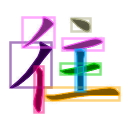

In [197]:
#笔画数据集
import random
from detectron2.utils.colormap import random_color

for d in random.sample(wanzheng1100dataset_dicts, 1):

    print(d)
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=wanzheng_metadata, scale=0.5)
    # vis = visualizer.draw_dataset_dict(d)
    #去掉类别的显示
    vis = visualizer.draw_dataset_dict_no_cls(d)
    
    cv2_imshow(vis.get_image()[:, :, ::-1])
    

    # visualizer1 = Visualizer(img[:, :, ::-1], metadata=wanzheng_metadata, scale=0.5)
    # annos = d.get("annotations", None)
    # if annos:
    #         if "segmentation" in annos[0]:
    #             masks = [x["segmentation"] for x in annos]
    #         else:
    #             masks = None
    # masks = visualizer1._convert_masks(masks) # _convert_masks:Convert different format of masks or polygons to a tuple of masks and polygons.
    # print(masks) # GenericMask:
    # num_instances = len(masks)
    # print(num_instances)


    # areas = np.asarray([x.area() for x in masks])
    # sorted_idxs = np.argsort(-areas).tolist()
    # masks = [masks[idx] for idx in sorted_idxs] if masks is not None else None
    
    # assigned_colors=None
    # if assigned_colors is None:
    #  assigned_colors = [random_color(rgb=True, maximum=1) for _ in range(num_instances)]

    # for i in range(num_instances):

    #   color = assigned_colors[i]
    #   for segment in masks[i].polygons: 
    #    print(segment.reshape(-1, 2))#获得每个分割图的坐标矩阵 polygons

    #    vis1 = visualizer1.draw_polygon(segment.reshape(-1, 2), color, alpha=0.5)
    #    cv2_imshow(vis1.get_image()) 


    # #   #  已知边界数组polygons 如何画出灰度图 python

      

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


## MaskRCNN模型

In [0]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("wzMRCNN", {}, "./drive/My Drive/pic566_28class/images566.json", "./drive/My Drive/pic566_28class/images")
# wanzheng_metadata = MetadataCatalog.get("wzMRCNN")
# wanzhengdataset_dicts = DatasetCatalog.get("wzMRCNN")

In [0]:
# 创建MaskRCNN模型
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg1 = get_cfg()
cfg1.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg1.DATASETS.TRAIN = ("wz1100",)
cfg1.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg1.DATALOADER.NUM_WORKERS = 4
# cfg1.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg1.MODEL.WEIGHTS ="/content/drive/My Drive/05171628-MR10000/model_final.pth"
cfg1.SOLVER.IMS_PER_BATCH = 10
cfg1.SOLVER.BASE_LR = 0.02
cfg1.SOLVER.MAX_ITER = 5000   # 300 iterations seems good enough, but you can certainly train longer
cfg1.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg1.MODEL.ROI_HEADS.NUM_CLASSES = 32 # 32 classes (data, fig, hazelnut)
cfg1.OUTPUT_DIR='/content/drive/My Drive/MR15000'
os.makedirs(cfg1.OUTPUT_DIR, exist_ok=True)


In [201]:
MRCNNtrainer = DefaultTrainer(cfg1)
MRCNNtrainer.resume_or_load(resume=False)
MRCNNtrainer.train()

[05/24 02:44:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

## 如何不显示cls??  I did!!!

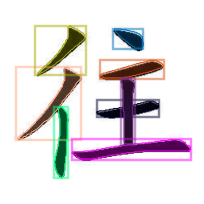

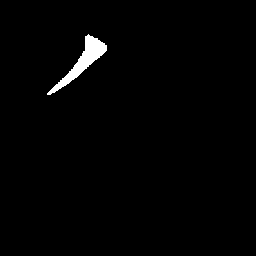

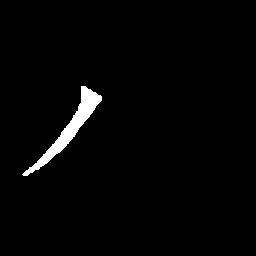

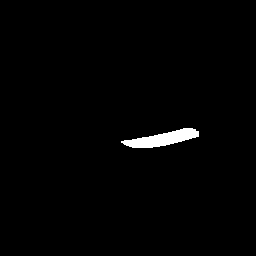

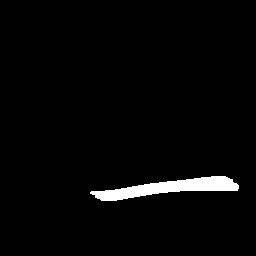

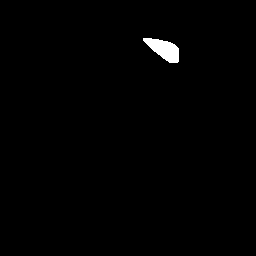

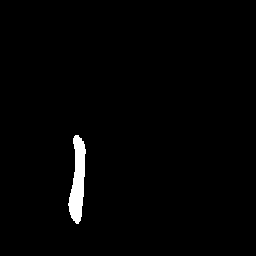

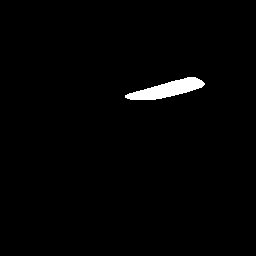

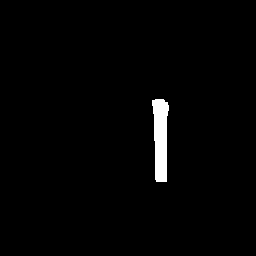

In [204]:
## 创建MaskRCNN模型
# cfg1.MODEL.WEIGHTS = os.path.join(cfg1.OUTPUT_DIR, "model_final.pth")
cfg1.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg1.DATASETS.TEST = ("wz", )
MRCNNpredictor = DefaultPredictor(cfg1)

from detectron2.utils.visualizer import ColorMode

for d in random.sample(wanzhengdataset_dicts, 1):    
    # im = cv2.imread(d["file_name"])
    im = cv2.imread('/content/drive/My Drive/pic566_28class/images/000396.jpg')
    outputs = MRCNNpredictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=wanzheng_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels用于实例化可视化的不同颜色模式  IMAGE_BW：与IMAGE相同，但将所有不带遮罩的区域转换为灰度。仅适用于按实例绘制蒙版预测
    )

    #重写的 函数 draw_instance_predictions_no_cls
    v = v.draw_instance_predictions_no_cls(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])


    #如何输出单独的mask
    masks=np.asarray(outputs["instances"].to("cpu").pred_masks)#[n,256,256]n为笔画数

    for mask in masks:
      mask=mask.astype("uint8")#mask从[false,flase]到[00001100]
      mask=mask*255       #变成二值图
      cv2_imshow(mask)



In [0]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir outputMRCNN

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("wz", cfg1, False, output_dir="./outputMRCNN/")#output_dir可选的输出目录，用于转储数据集上预测的所有结果。转储包含两个文件 "instance_predictions.pth" “ coco_instances_results.json”
val_loader = build_detection_test_loader(cfg1, "wz")
inference_on_dataset(MRCNNtrainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test


In [205]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = MRCNNpredictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.07,fps:14.53


## Pointrend模型

In [206]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()

# Add PointRend-specific config
point_rend.add_pointrend_config(cfg)
cfg.MODEL.POINT_HEAD.NUM_CLASSES = 32#修改POINT_HEAD.NUM_CLASSES 32 默认值为80

cfg.merge_from_file("/content/detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")
# cfg.merge_from_file("https://github.com/facebookresearch/detectron2/blob/master/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")
cfg.DATASETS.TRAIN = ("wz1100",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 4

# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
# cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_3c3198.pkl"
cfg.MODEL.WEIGHTS ='/content/drive/My Drive/pp25000/model_final.pth'
cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 25000    # 3000 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE =256   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 32  # 28 classes (heng,shu....)
cfg.MODEL.POINT_HEAD.NUM_CLASSES = 32#修改POINT_HEAD.NUM_CLASSES 32 默认值为80
cfg.OUTPUT_DIR='/content/drive/My Drive/pp25000'
#正式训练
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/24 02:48:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [0]:
#PointRend输出高分辨率分割图

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()

# Add PointRend-specific config
point_rend.add_pointrend_config(cfg)
cfg.MODEL.POINT_HEAD.NUM_CLASSES = 32#修改POINT_HEAD.NUM_CLASSES 32 默认值为80

cfg.merge_from_file("/content/detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")
# cfg.merge_from_file("https://github.com/facebookresearch/detectron2/blob/master/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")
cfg.DATASETS.TRAIN = ("wz1100",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 4

# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
# cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_3c3198.pkl"
cfg.MODEL.WEIGHTS ='/content/drive/My Drive/05171809-pp15000/model_final.pth'
cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 25000    # 3000 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE =256   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 32  # 28 classes (heng,shu....)
cfg.MODEL.POINT_HEAD.NUM_CLASSES = 32#修改POINT_HEAD.NUM_CLASSES 32 默认值为80
cfg.OUTPUT_DIR='/content/drive/My Drive/pp2500'
#正式训练
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [0]:
print(cfg)

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [0]:
# Look at training curves in tensorboard:
%load_ext tensorboard
# %tensorboard --logdir  output
%tensorboard --logdir "/content/drive/My Drive/05171809-pp15000"

## inference

In [207]:
#注册inference的数据集
from detectron2.data.datasets import register_coco_instances
register_coco_instances("wzInfer", {}, "./drive/My Drive/pic566_28class/images566.json", "./drive/My Drive/pic566_28class/images")
wanzheng_metadata = MetadataCatalog.get("wzInfer")
wanzhengdataset_dicts = DatasetCatalog.get("wzInfer")

[05/24 02:48:54 d2.data.datasets.coco]: Loaded 566 images in COCO format from ./drive/My Drive/pic566_28class/images566.json


In [0]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS ="/content/drive/My Drive/pp25000/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("wzInfer", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

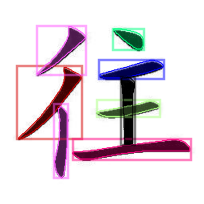

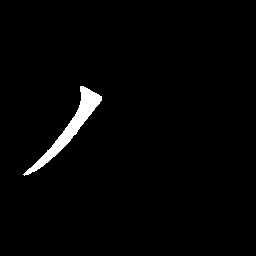

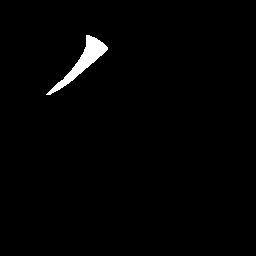

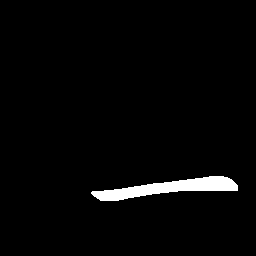

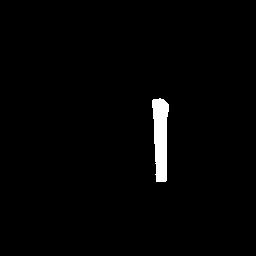

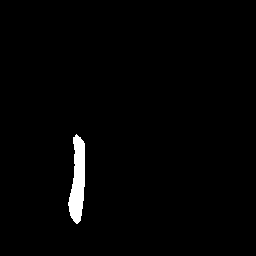

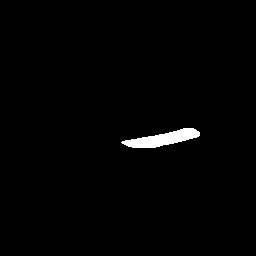

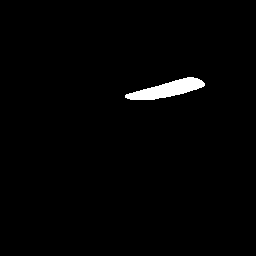

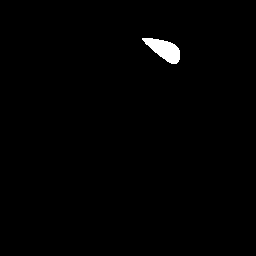

In [209]:
from detectron2.utils.visualizer import ColorMode
import random

for d in random.sample(wanzhengdataset_dicts, 1):    
#     im = cv2.imread(d["file_name"])
    im = cv2.imread('/content/drive/My Drive/pic566_28class/images/000396.jpg') #使用活字 的图片
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=wanzheng_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels用于实例化可视化的不同颜色模式  IMAGE_BW：与IMAGE相同，但将所有不带遮罩的区域转换为灰度。仅适用于按实例绘制蒙版预测
    )
    # v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    v = v.draw_instance_predictions_no_cls(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])


    #如何输出单独的mask
    masks=np.asarray(outputs["instances"].to("cpu").pred_masks)#[n,256,256]n为笔画数
    count=0
    for mask in masks:
      mask=mask.astype("uint8")#mask从[false,flase]到[00001100]
      mask=mask*255       #变成二值图
      cv2_imshow(mask)

      count=count+1
      file_path="/content/ppqiu/"+str(count)+".jpg"
      cv2.imwrite(file_path,mask)


In [0]:
wanzheng_metadata

Metadata(evaluator_type='coco', image_root='./drive/My Drive/pic566_28class/images', json_file='./drive/My Drive/pic566_28class/images566.json', name='wzInfer', thing_classes=['piezhe', 'heng', 'hengzhewangou', 'pie', 'na', 'shuwangou', 'henggou', 'shugou', 'hengzhegou', 'hengzhezhezhegou', 'hengpie', 'shu', 'shuzhezhegou', 'dian', 'wangou', 'ti', 'shuti', 'shuzhe', 'wogou', 'hengzhe', 'xiegou', 'hengzhezhepie', 'hengzhewan', 'piedian', 'shuzhepie', 'hengxiegou', 'hengzheti', 'shuwan'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27})

We can also evaluate its performance using AP metric implemented in COCO API. This gives an AP of ~70%. Not bad!

In [0]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('wzInfer',)
  TRAIN: ('wz1100',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: bitmask
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0], [0.5, 1.0, 2.0], [0.5, 1.0, 2.0], [0.5, 1.0, 2.0], [0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum

## **检验效果---AP**

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("wz", cfg, False, output_dir="./output/")#output_dir可选的输出目录，用于转储数据集上预测的所有结果。转储包含两个文件 "instance_predictions.pth" “ coco_instances_results.json”
val_loader = build_detection_test_loader(cfg, "wz")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test


[05/18 02:48:11 d2.data.datasets.coco]: Loaded 680 images in COCO format from ./drive/My Drive/pic32/train.json
[05/18 02:48:12 d2.data.common]: Serializing 680 elements to byte tensors and concatenating them all ...
[05/18 02:48:12 d2.data.common]: Serialized dataset takes 1.66 MiB
[05/18 02:48:12 d2.evaluation.evaluator]: Start inference on 680 images
[05/18 02:48:13 d2.evaluation.evaluator]: Inference done 11/680. 0.0643 s / img. ETA=0:00:44
[05/18 02:48:18 d2.evaluation.evaluator]: Inference done 83/680. 0.0666 s / img. ETA=0:00:41
[05/18 02:48:23 d2.evaluation.evaluator]: Inference done 155/680. 0.0664 s / img. ETA=0:00:36
[05/18 02:48:28 d2.evaluation.evaluator]: Inference done 225/680. 0.0668 s / img. ETA=0:00:32
[05/18 02:48:33 d2.evaluation.evaluator]: Inference done 297/680. 0.0666 s / img. ETA=0:00:26
[05/18 02:48:38 d2.evaluation.evaluator]: Inference done 370/680. 0.0665 s / img. ETA=0:00:21
[05/18 02:48:43 d2.evaluation.evaluator]: Inference done 441/680. 0.0665 s / img. 

OrderedDict([('bbox',
              {'AP': 90.3416718745117,
               'AP-dian': 82.53758467269509,
               'AP-heng': 82.67057791918447,
               'AP-henggou': 87.07711784844084,
               'AP-hengpie': 88.8585281521117,
               'AP-hengpiewangou': 94.41301272984441,
               'AP-hengxiegou': 98.56985698569856,
               'AP-hengzhe': 86.54937107892759,
               'AP-hengzhegou': 90.7289711886034,
               'AP-hengzheti': 55.12211221122109,
               'AP-hengzhewan': 93.28147100424327,
               'AP-hengzhewangou': 93.10643564356435,
               'AP-hengzhezhe': 95.56705670567057,
               'AP-hengzhezhepie': 94.54020402040206,
               'AP-hengzhezhezhe': 100.0,
               'AP-hengzhezhezhegou': 90.99952852428099,
               'AP-na': 93.35891066427713,
               'AP-pie': 89.13138016772601,
               'AP-piedian': 94.10891089108911,
               'AP-piezhe': 89.82482557424625,
          

## Benchmark inference speed

In [210]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.08,fps:13.00
